In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math
import time

from Data import *
from nets.hyper_net import HyperNetwork 
from flows.build import build_flow
from plot_utils import plot_cnf_animation

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def base_dist():
    return Normal(
        loc=torch.zeros(2, device=device),
        scale=torch.ones(2, device=device),
    )

In [4]:
batch_size = 32
dset = 'two_blobs'
Data = Data(dset +'.csv')
d = Data.read_csv().to(device)

train_dataloader, test_dataloader = Data.return_dataloaders(batch_size = batch_size)

num_batches = train_dataloader.__len__()
 

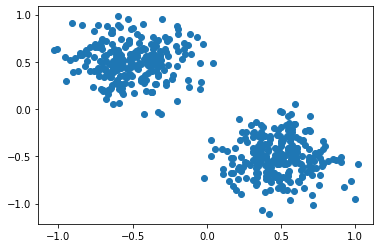

In [5]:
Data.plot_scatter()

## CNF

In [6]:
'''
t1 sample 
flow(t1) = t0
t1_ = t0 -log p diff t0

prob(t1_) as high as possible 

'''

'\nt1 sample \nflow(t1) = t0\nt1_ = t0 -log p diff t0\n\nprob(t1_) as high as possible \n\n'

In [7]:
# model and flow parameters
hidden_dim = 32
width      = 64
t0 = 0  # flow start time
t1 = 1  # flow end time

net = HyperNetwork(in_out_dim=2, hidden_dim=hidden_dim, width=width)

In [8]:
flow_cnf = build_flow(name = 'continuous', net = net,  dim= 1, device = device).flow.to(device)

In [9]:
flow_cnf

Flow(
  (flow): ModuleList(
    (0): CNF(
      (net): HyperNetwork(
        (fc1): Linear(in_features=1, out_features=32, bias=True)
        (fc2): Linear(in_features=32, out_features=32, bias=True)
        (fc3): Linear(in_features=32, out_features=448, bias=True)
      )
    )
  )
)

In [ ]:
start  = time.time()

#Train

optimizer = torch.optim.Adam(flow_cnf.parameters(), lr=3e-3)

epochs = 100 #300

print('Training...')
flow_cnf = flow_cnf.train()
ts = torch.tensor([t1, t0]).type(torch.float32).to(device) # for training, we flow the samples backward (in time) 
a=0
z0=[]

for epoch in range(1, epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_dataloader):
        x1 = x.to(device)
        optimizer.zero_grad()
        a+= x1.size()[0]
        # initialize initial densities
        logp_diff_t1 = torch.zeros(x1.size()[0], 1).type(torch.float32).to(device)

        # compute the backward solutions
        ip = (ts, x1, logp_diff_t1)
        z_t,  logp_diff_t  = flow_cnf.flow_outputs(ip) # outputs time first
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        z0.append(z_t0.detach().cpu())

        # compute the density of each sample
        logp_x = base_dist().log_prob(z_t0).to(device) - logp_diff_t0 #.view(-1)
        loss   = -logp_x.mean(0)
        loss.sum().backward()
        optimizer.step()
        loss_sum += loss.sum().detach().cpu().item()
        
    if epoch %1 == 0 :    
        print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch, epochs, loss_sum/len(train_dataloader)))
flow_cnf = flow_cnf.eval()

end = time.time()
print('Training takes ', (end-start)/3600, ' hrs')
        


Training...
Epoch: 1/100, Loss: 1.783
Epoch: 2/100, Loss: 0.008
Epoch: 3/100, Loss: -0.594
Epoch: 4/100, Loss: -0.868
Epoch: 5/100, Loss: -0.966
Epoch: 6/100, Loss: -1.351
Epoch: 7/100, Loss: -1.089
Epoch: 8/100, Loss: -1.567
Epoch: 9/100, Loss: -1.894
Epoch: 10/100, Loss: -1.869
Epoch: 11/100, Loss: -2.028
Epoch: 12/100, Loss: -1.916
Epoch: 13/100, Loss: -1.921
Epoch: 14/100, Loss: -1.988
Epoch: 15/100, Loss: -2.171
Epoch: 16/100, Loss: -2.155
Epoch: 17/100, Loss: -2.427
Epoch: 18/100, Loss: -2.106
Epoch: 19/100, Loss: -2.274
Epoch: 20/100, Loss: -2.337
Epoch: 21/100, Loss: -2.233
Epoch: 22/100, Loss: -2.295
Epoch: 23/100, Loss: -2.383
Epoch: 24/100, Loss: -2.280
Epoch: 25/100, Loss: -2.085
Epoch: 26/100, Loss: -2.079
Epoch: 27/100, Loss: -2.208
Epoch: 28/100, Loss: -2.213
Epoch: 29/100, Loss: -2.543
Epoch: 30/100, Loss: -2.213
Epoch: 31/100, Loss: -2.341
Epoch: 32/100, Loss: -2.344
Epoch: 33/100, Loss: -2.387
Epoch: 34/100, Loss: -2.466
Epoch: 35/100, Loss: -2.474
Epoch: 36/100, Loss

In [ ]:
z = flow_cnf.sample(450)[0]
x_dash = flow_cnf.sample(450)[1]

fig = Data.plot_samples(z, x_dash, r'z ~ p(z)', r'X = g(z)')
fig.savefig('results/CNF_'+ dset +'_1.pdf')

## Back to prior space

In [ ]:
### After training

logp_diff_t1 = torch.zeros(d.size()[0], 1).type(torch.float32).to(device) 

ip = (ts, d, logp_diff_t1)
z_t,  logp_diff_t  = flow_cnf.flow_outputs(ip) # outputs time first
z_t0, _ = z_t[-1], logp_diff_t[-1]

fig = Data.plot_samples(d, z_t0, r'X ~ p(X)', r'z = f(X)')
fig.savefig('results/CNF_'+ dset +'_2.pdf'')